In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import chi2

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE

In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/Exploratory Project/Back_order_train.csv")
train_data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1687861, 23)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [ ]:
train_data.tail()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_data.loc[train_data["national_inv"].isnull()]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Dropping the row having all null values.
train_data.drop(index=1687860, axis=0, inplace=True)

In [ ]:
train_data["sku"]=train_data["sku"].astype(int)

In [ ]:
## Performing One Hot Encoding on categorical features.

train_data=pd.get_dummies(train_data, drop_first=True)
train_data

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,went_on_backorder_Yes
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0.0,0,0,0,0,1,0,0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.99,0.0,0,0,0,0,1,0,0
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0,0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.13,0.0,0,0,0,0,1,0,0
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,-99.00,-99.00,0.0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687855,1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,0.0,0.69,0.69,5.0,0,1,0,0,1,0,0
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,0.0,-99.00,-99.00,1.0,0,0,0,0,1,0,0
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,0.0,0.86,0.84,1.0,0,1,0,0,0,0,1
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,0.0,0.86,0.84,6.0,0,0,0,0,1,0,0


In [ ]:
train_data.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,went_on_backorder_Yes
count,1.687860e+06,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,2.094460e+06,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01,5.373668e-04,2.295706e-01,1.451542e-04,1.207648e-01,9.638086e-01,4.330928e-04,6.690721e-03
std,6.730819e+05,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01,2.317495e-02,4.205568e-01,1.204713e-02,3.258538e-01,1.867661e-01,2.080638e-02,8.152275e-02
min,1.026827e+06,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.533484e+06,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.955448e+06,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,2.862954e+06,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,3.284919e+06,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
train_data.isnull().sum()

sku                           0
national_inv                  0
lead_time                100893
in_transit_qty                0
forecast_3_month              0
forecast_6_month              0
forecast_9_month              0
sales_1_month                 0
sales_3_month                 0
sales_6_month                 0
sales_9_month                 0
min_bank                      0
pieces_past_due               0
perf_6_month_avg              0
perf_12_month_avg             0
local_bo_qty                  0
potential_issue_Yes           0
deck_risk_Yes                 0
oe_constraint_Yes             0
ppap_risk_Yes                 0
stop_auto_buy_Yes             0
rev_stop_Yes                  0
went_on_backorder_Yes         0
dtype: int64

In [ ]:
train_data[["perf_6_month_avg", "perf_12_month_avg"]].describe()

,perf_6_month_avg,perf_12_month_avg
count,1.687860e+06,1.687860e+06
mean,-6.872059e+00,-6.437947e+00
std,2.655636e+01,2.584333e+01
min,-9.900000e+01,-9.900000e+01
25%,6.300000e-01,6.600000e-01
50%,8.200000e-01,8.100000e-01
75%,9.700000e-01,9.500000e-01
max,1.000000e+00,1.000000e+00


In [ ]:
train_data['went_on_backorder_Yes'].sum()

11293

In [ ]:
train_data['went_on_backorder_Yes'].mean()

0.006690720794378681

In [ ]:
## The Data We have is highly imbalanced, Only 0.66% of Data points belong to class 1 and the rest of data points i.e 99.34% belong to class 0.



## national_inv

In [ ]:
## "national_inv" is highly skewed towards right.
train_data["national_inv"].skew()

340.2858003326191

In [ ]:
## Products that have Neagtive value of "national_inv" are 15% likely to go in backorder, while overall only 0.66% of products went in backorder
train_data.loc[train_data["national_inv"]<0, "went_on_backorder_Yes"].mean()

0.15115489130434784

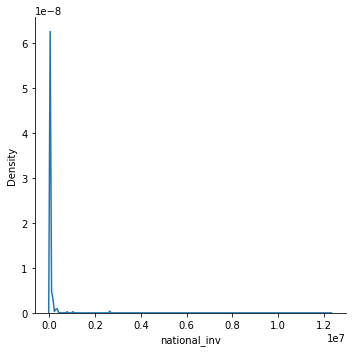

In [ ]:
sns.displot(data=train_data, x="national_inv", kind="kde")

## lead_time

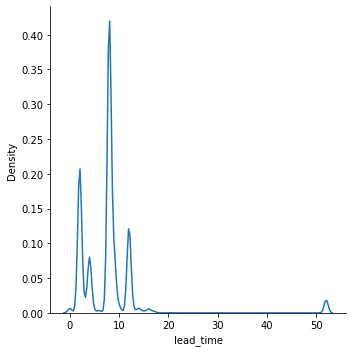

In [ ]:
sns.displot(data=train_data, x="lead_time", kind="kde")

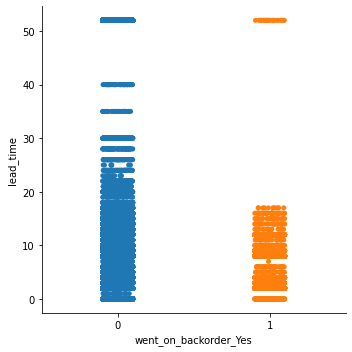

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="lead_time")

In [ ]:
## By above graph we can see that products that have high lead_time didn't went on backorder, 
## while products that went on backorder were having low value of lead_time, by this we can assume that the company gives more attention to demand-supply 
## balance of products that have high lead_time.

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "lead_time"].mean()

6.322545355091622

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "lead_time"].median()

8.0

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "lead_time"].mean()

7.883053151082679

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "lead_time"].median()

8.0

In [ ]:
train_data["lead_time"].isnull().sum()

100893

In [ ]:
train_data["lead_time"].skew()

4.556295427885091

## in_transit_qty

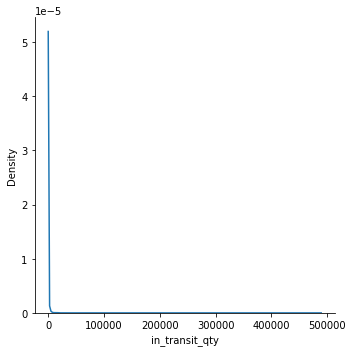

In [ ]:
sns.displot(data=train_data, x="in_transit_qty", kind="kde")

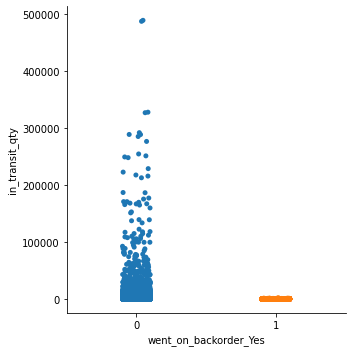

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="in_transit_qty")

In [ ]:
## Products that have very high "in_transit_qty" didn't went on backorder because, perhaps their adequate supply was ensured.

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "in_transit_qty"].mean()

4.338616842291685

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "in_transit_qty"].max()

2259.0

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "in_transit_qty"].mean()

44.319523168474625

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "in_transit_qty"].max()

489408.0

In [ ]:
train_data["in_transit_qty"].skew()

166.18340424761558

## forecast_3,6,9_month

In [ ]:
train_data[["forecast_3_month","forecast_6_month", "forecast_9_month"]].skew()

forecast_3_month    138.968325
forecast_6_month    138.961427
forecast_9_month    143.298875
dtype: float64

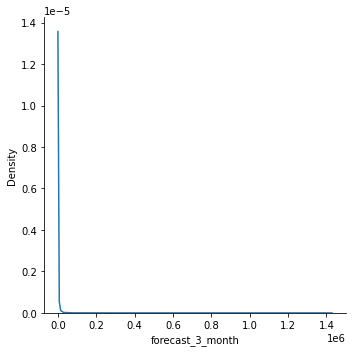

In [ ]:
sns.displot(data=train_data, x="forecast_3_month", kind="kde")

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1,"forecast_3_month"].median()

12.0

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0,"forecast_3_month"].median()

0.0

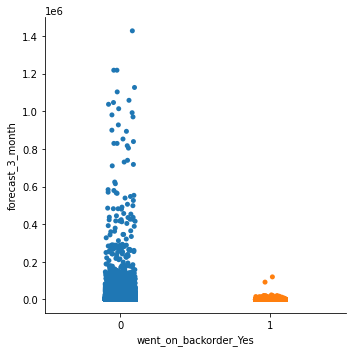

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="forecast_3_month")

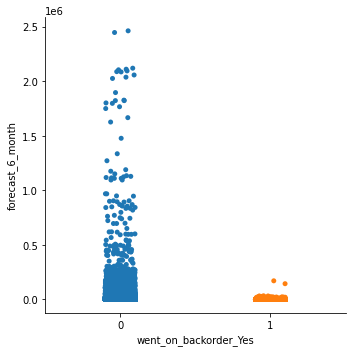

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="forecast_6_month")

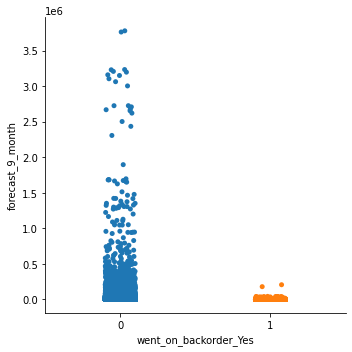

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="forecast_9_month")

## perf_6_month_avg, perf_12_month_avg

In [ ]:
train_data.loc[train_data["perf_6_month_avg"]==-99, "sku"].count()

129478

In [ ]:
train_data.loc[train_data["perf_6_month_avg"]==-99, 'went_on_backorder_Yes'].mean()

0.0033210275104650984

In [ ]:
train_data.loc[train_data["perf_6_month_avg"]!=-99, 'went_on_backorder_Yes'].mean()

0.00697069139658954

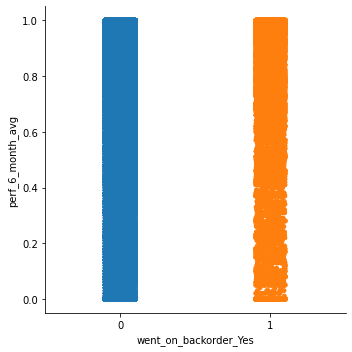

In [ ]:
sns.catplot(data=train_data.loc[train_data["perf_6_month_avg"]!=-99], x="went_on_backorder_Yes", y="perf_6_month_avg")

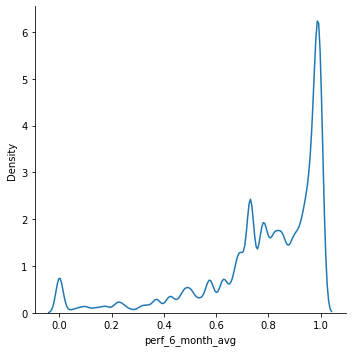

In [ ]:
sns.displot(data=train_data.loc[train_data["perf_6_month_avg"]!=-99], x="perf_6_month_avg", kind="kde")

In [ ]:
train_data.loc[train_data["perf_12_month_avg"]==-99, "sku"].count()

122050

In [ ]:
train_data.loc[train_data["perf_12_month_avg"]==-99, "went_on_backorder_Yes"].mean()

0.0032363785333879556

In [ ]:
train_data.loc[train_data["perf_12_month_avg"]!=-99, "went_on_backorder_Yes"].mean()

0.006959975986869416

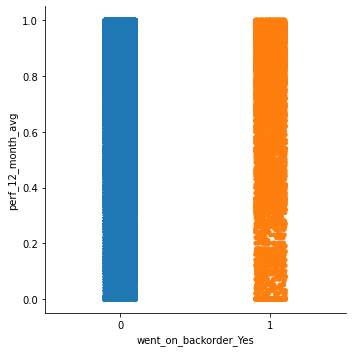

In [ ]:
sns.catplot(data=train_data.loc[train_data["perf_12_month_avg"]!=-99], x="went_on_backorder_Yes", y="perf_12_month_avg")

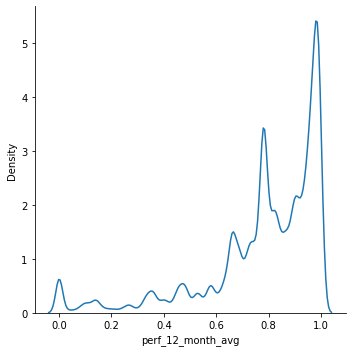

In [ ]:
sns.displot(data=train_data.loc[train_data["perf_6_month_avg"]!=-99], x="perf_12_month_avg", kind="kde")

In [ ]:
train_data[["perf_6_month_avg", "perf_12_month_avg"]].skew()

perf_6_month_avg    -3.180622
perf_12_month_avg   -3.302181
dtype: float64

## local_bo_qty

In [ ]:
train_data["local_bo_qty"].isnull().sum()

0

In [ ]:
train_data["local_bo_qty"].skew()

165.19054793748316

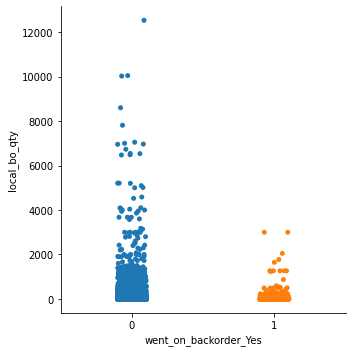

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="local_bo_qty")

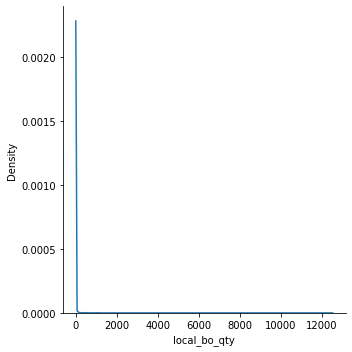

In [ ]:
sns.displot(data=train_data, x="local_bo_qty", kind="kde")

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "local_bo_qty"].mean()

4.531391127246967

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "local_bo_qty"].median()

0.0

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "local_bo_qty"].mean()

0.6001478020264027

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "local_bo_qty"].median()

0.0

## min_bank

In [ ]:
train_data["min_bank"].skew()

131.21264893012795

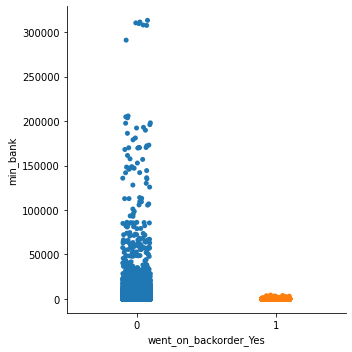

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="min_bank")

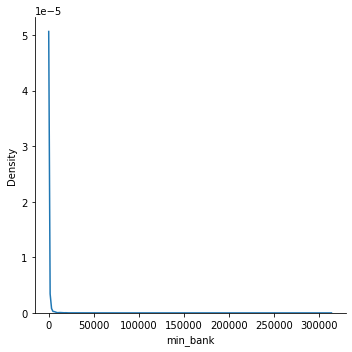

In [ ]:
sns.displot(data=train_data, x="min_bank", kind="kde")

## sales_1,3,6,9_month

In [ ]:
train_data["sales_1_month"].skew()

196.1199898556541

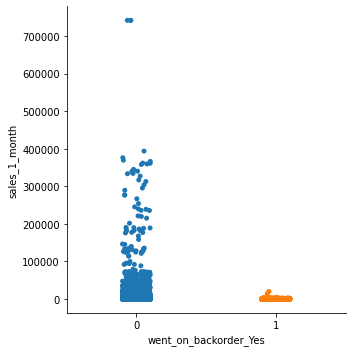

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="sales_1_month")

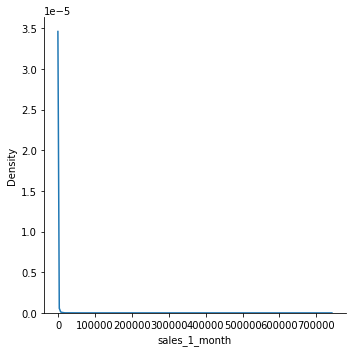

In [ ]:
sns.displot(data=train_data, x="sales_1_month", kind="kde")

## pieces_past_due

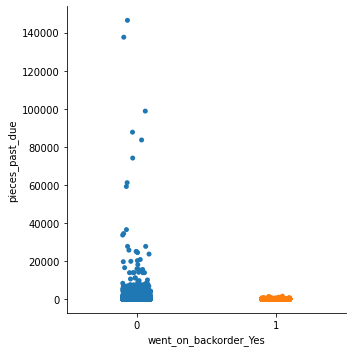

In [ ]:
sns.catplot(data=train_data, x="went_on_backorder_Yes", y="pieces_past_due")

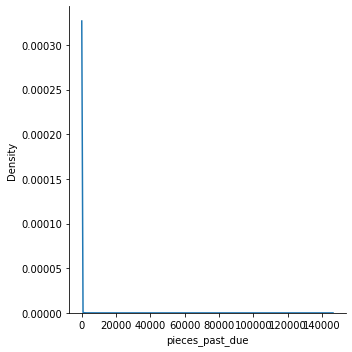

In [ ]:
sns.displot(data=train_data, x="pieces_past_due", kind="kde")

In [ ]:
train_data["pieces_past_due"].skew()

412.39190039252696

## Categorical variables and feature selection.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   sku                    1687860 non-null  int64  
 1   national_inv           1687860 non-null  float64
 2   lead_time              1586967 non-null  float64
 3   in_transit_qty         1687860 non-null  float64
 4   forecast_3_month       1687860 non-null  float64
 5   forecast_6_month       1687860 non-null  float64
 6   forecast_9_month       1687860 non-null  float64
 7   sales_1_month          1687860 non-null  float64
 8   sales_3_month          1687860 non-null  float64
 9   sales_6_month          1687860 non-null  float64
 10  sales_9_month          1687860 non-null  float64
 11  min_bank               1687860 non-null  float64
 12  pieces_past_due        1687860 non-null  float64
 13  perf_6_month_avg       1687860 non-null  float64
 14  perf_12_month_avg 

In [ ]:
temp=chi2(train_data[["potential_issue_Yes", "deck_risk_Yes", "oe_constraint_Yes", "ppap_risk_Yes", "stop_auto_buy_Yes",
                      "rev_stop_Yes"]], train_data["went_on_backorder_Yes"])
temp

(array([334.91720798, 177.7369123 ,  24.8482819 , 115.29428917,
          0.35888955,   4.92386108]),
 array([8.16274987e-75, 1.51203244e-40, 6.20243017e-07, 6.78439184e-27,
        5.49123596e-01, 2.64882563e-02]))

In [ ]:
train_data["potential_issue_Yes"].sum()

907

In [ ]:
matrix=pd.crosstab(train_data["potential_issue_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["potential_issue_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["potential_issue_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
potential_issue_Yes,,
0,99.333591,0.666409
1,94.377067,5.622933


In [ ]:
train_data["deck_risk_Yes"].sum()

387483

In [ ]:
matrix=pd.crosstab(train_data["deck_risk_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["deck_risk_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["deck_risk_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
deck_risk_Yes,,
0,99.278901,0.721099
1,99.505527,0.494473


In [ ]:
train_data["oe_constraint_Yes"].sum()

245

In [ ]:
matrix=pd.crosstab(train_data["oe_constraint_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["oe_constraint_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["oe_constraint_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
oe_constraint_Yes,,
0,99.331305,0.668695
1,96.734694,3.265306


In [ ]:
train_data["ppap_risk_Yes"].sum()

203834

In [ ]:
matrix=pd.crosstab(train_data["ppap_risk_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["ppap_risk_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["ppap_risk_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
ppap_risk_Yes,,
0,99.357558,0.642442
1,99.137043,0.862957


In [ ]:
train_data.loc[train_data["stop_auto_buy_Yes"]==0, "stop_auto_buy_Yes"].count()

61086

In [ ]:
matrix=pd.crosstab(train_data["stop_auto_buy_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["stop_auto_buy_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["stop_auto_buy_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
stop_auto_buy_Yes,,
0,99.228956,0.771044
1,99.334757,0.665243


In [ ]:
train_data["rev_stop_Yes"].sum()

731

In [ ]:
matrix=pd.crosstab(train_data["rev_stop_Yes"], train_data["went_on_backorder_Yes"])
matrix=matrix/(np.array([[train_data.loc[train_data["rev_stop_Yes"]==0].shape[0]],
                       [train_data.loc[train_data["rev_stop_Yes"]==1].shape[0]]]))
matrix=matrix*100
matrix

went_on_backorder_Yes,0,1
rev_stop_Yes,,
0,99.330638,0.669362
1,100.000000,0.000000


In [ ]:
# According to chi2 test I am dropping out categorical columns which have p value more than 0.02

In [ ]:
train_data.drop(["stop_auto_buy_Yes", "rev_stop_Yes"], axis=1, inplace=True)

In [ ]:
train_data.isnull().sum()

sku                           0
national_inv                  0
lead_time                100893
in_transit_qty                0
forecast_3_month              0
forecast_6_month              0
forecast_9_month              0
sales_1_month                 0
sales_3_month                 0
sales_6_month                 0
sales_9_month                 0
min_bank                      0
pieces_past_due               0
perf_6_month_avg              0
perf_12_month_avg             0
local_bo_qty                  0
potential_issue_Yes           0
deck_risk_Yes                 0
oe_constraint_Yes             0
ppap_risk_Yes                 0
went_on_backorder_Yes         0
dtype: int64

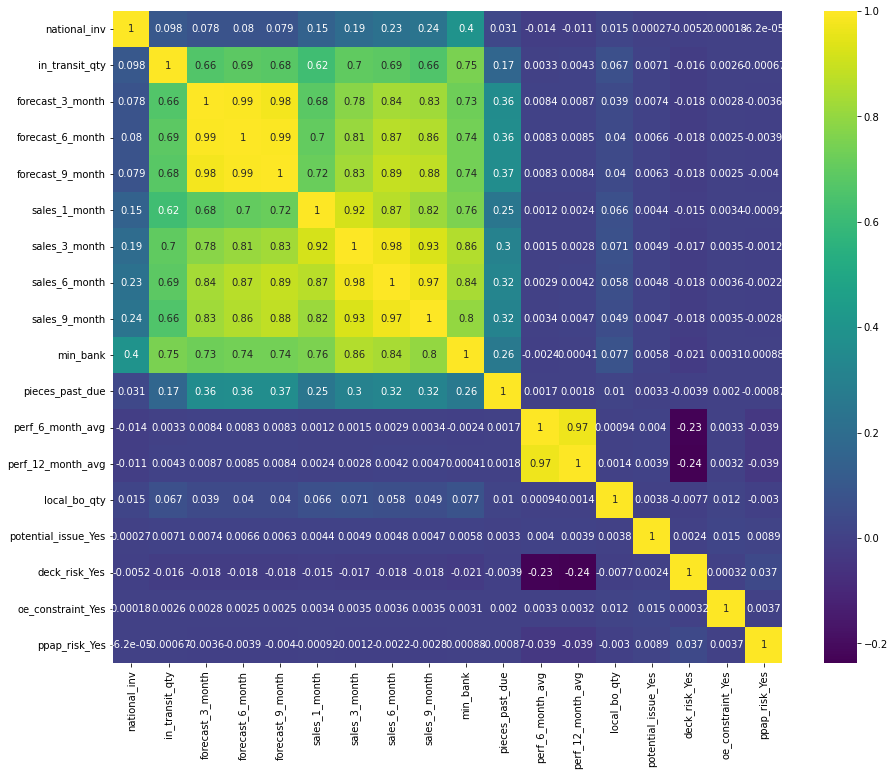

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.drop(["sku", "went_on_backorder_Yes", "lead_time"], axis=1).corr(), cmap="viridis", annot=True)

In [ ]:
train_data.drop("min_bank", axis=1, inplace=True)
train_data["forecast_sales"]=(train_data["forecast_3_month"]+train_data["forecast_6_month"]+train_data["forecast_9_month"])/3
train_data["sales_past"]=(train_data["sales_1_month"]+train_data["sales_3_month"]+train_data["sales_6_month"]+train_data["sales_9_month"])/4
train_data["perf_past"]=(train_data["perf_6_month_avg"]+train_data["perf_12_month_avg"])/2
train_data.drop(["sales_1_month", "sales_3_month", "sales_6_month", "sales_9_month", "forecast_3_month", "forecast_6_month", 
                 "forecast_9_month","perf_6_month_avg", "perf_12_month_avg"], axis=1, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 14 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   sku                    1687860 non-null  int64  
 1   national_inv           1687860 non-null  float64
 2   lead_time              1586967 non-null  float64
 3   in_transit_qty         1687860 non-null  float64
 4   pieces_past_due        1687860 non-null  float64
 5   local_bo_qty           1687860 non-null  float64
 6   potential_issue_Yes    1687860 non-null  uint8  
 7   deck_risk_Yes          1687860 non-null  uint8  
 8   oe_constraint_Yes      1687860 non-null  uint8  
 9   ppap_risk_Yes          1687860 non-null  uint8  
 10  went_on_backorder_Yes  1687860 non-null  uint8  
 11  forecast_sales         1687860 non-null  float64
 12  sales_past             1687860 non-null  float64
 13  perf_past              1687860 non-null  float64
dtypes: float64(8), int

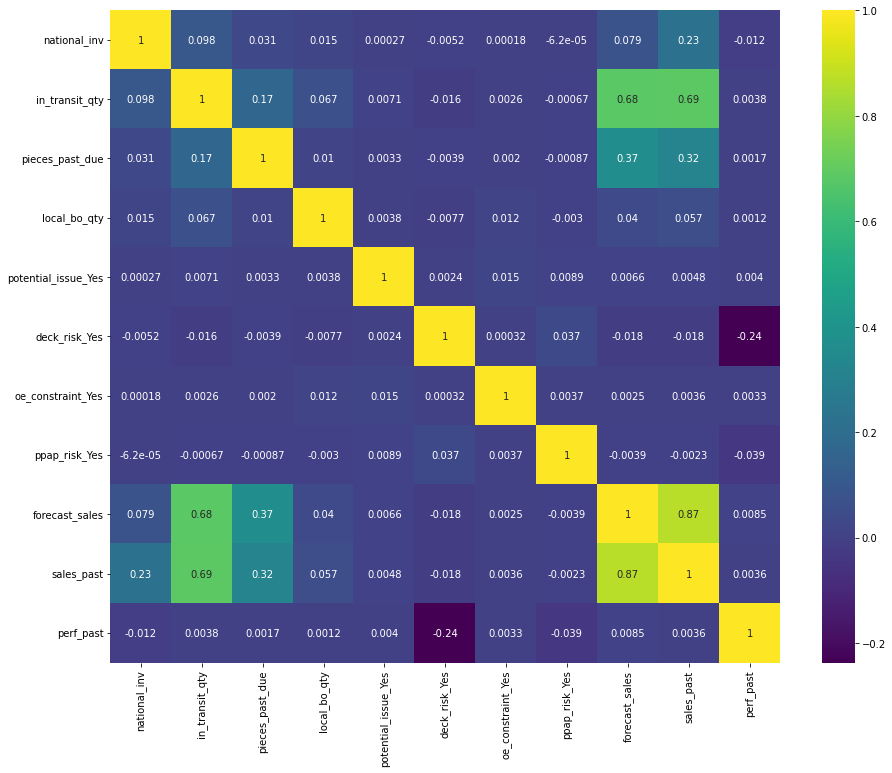

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.drop(["sku", "went_on_backorder_Yes", "lead_time"], axis=1).corr(), cmap="viridis", annot=True)

In [ ]:
## dropping forecast_sales as forecast_sales and sales_past are highly coorelated.

In [ ]:
train_data.drop(["forecast_sales"], axis=1, inplace=True)

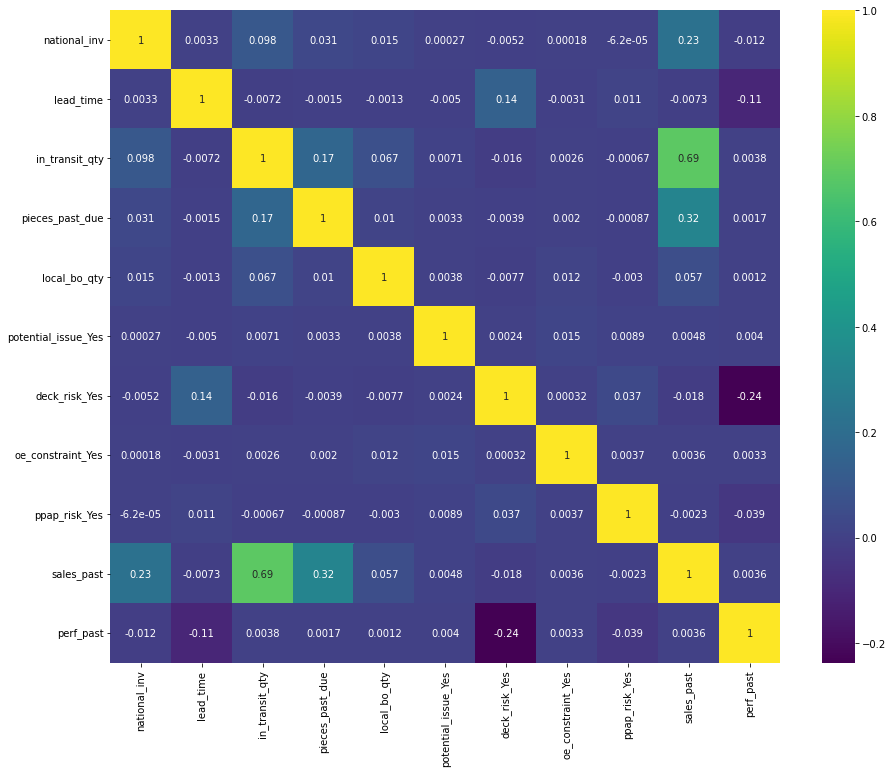

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(train_data.drop(["sku", "went_on_backorder_Yes"], axis=1).corr(), cmap="viridis", annot=True)

## Imputing missing values.

In [ ]:
train_data.isnull().sum()

sku                           0
national_inv                  0
lead_time                100893
in_transit_qty                0
pieces_past_due               0
local_bo_qty                  0
potential_issue_Yes           0
deck_risk_Yes                 0
oe_constraint_Yes             0
ppap_risk_Yes                 0
went_on_backorder_Yes         0
sales_past                    0
perf_past                     0
dtype: int64

In [ ]:
imputer = IterativeImputer(max_iter=10,random_state=0)
X_train = imputer.fit_transform(train_data.drop(["went_on_backorder_Yes", "sku"], axis=1))
X_train = pd.DataFrame(X_train, columns=train_data.drop(["went_on_backorder_Yes", "sku"], axis=1).columns)
y_train = train_data["went_on_backorder_Yes"]
X_train

,national_inv,lead_time,in_transit_qty,pieces_past_due,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,sales_past,perf_past
0,0.0,13.261989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-99.000
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.990
2,2.0,15.725412,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,-99.000
3,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.115
4,8.0,15.725412,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.00,-99.000
...,...,...,...,...,...,...,...,...,...,...,...
1687855,0.0,2.000000,0.0,0.0,5.0,0.0,1.0,0.0,0.0,4.75,0.690
1687856,-1.0,13.261995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.75,-99.000
1687857,-1.0,9.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,7.75,0.850
1687858,62.0,9.000000,16.0,0.0,6.0,0.0,0.0,0.0,0.0,114.00,0.850


In [ ]:
X_train.isnull().sum()

national_inv           0
lead_time              0
in_transit_qty         0
pieces_past_due        0
local_bo_qty           0
potential_issue_Yes    0
deck_risk_Yes          0
oe_constraint_Yes      0
ppap_risk_Yes          0
sales_past             0
perf_past              0
dtype: int64

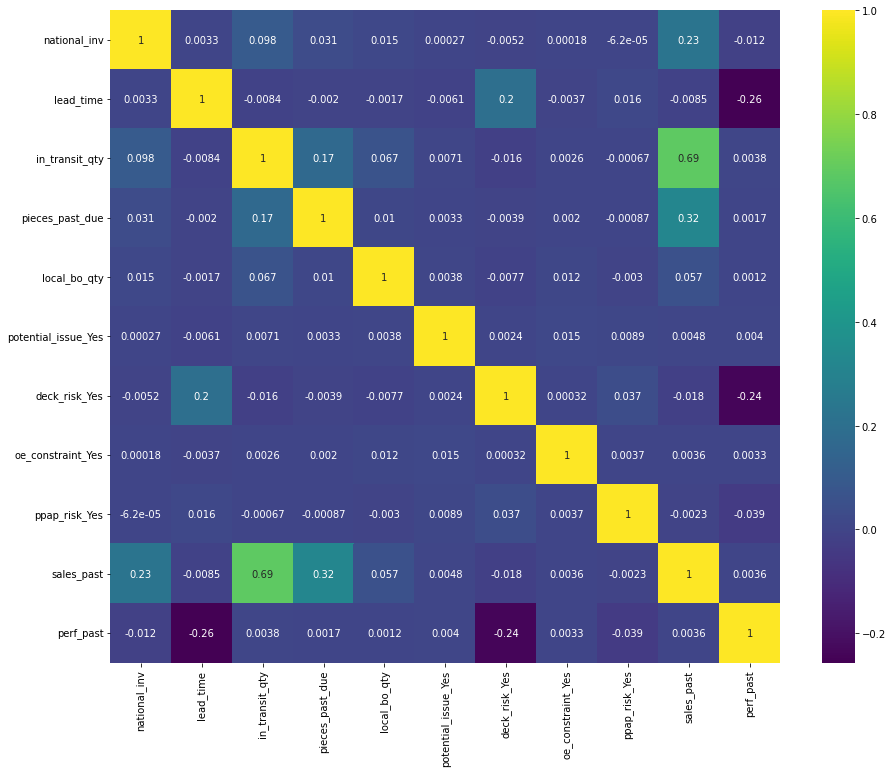

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(X_train.corr(), cmap="viridis", annot=True)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687860 entries, 0 to 1687859
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   national_inv         1687860 non-null  float64
 1   lead_time            1687860 non-null  float64
 2   in_transit_qty       1687860 non-null  float64
 3   pieces_past_due      1687860 non-null  float64
 4   local_bo_qty         1687860 non-null  float64
 5   potential_issue_Yes  1687860 non-null  float64
 6   deck_risk_Yes        1687860 non-null  float64
 7   oe_constraint_Yes    1687860 non-null  float64
 8   ppap_risk_Yes        1687860 non-null  float64
 9   sales_past           1687860 non-null  float64
 10  perf_past            1687860 non-null  float64
dtypes: float64(11)
memory usage: 141.7 MB


## Undersampling and Oversampling Data

In [ ]:
Counter(y_train)

Counter({0: 1676567, 1: 11293})

In [ ]:
undersampler=RandomUnderSampler(sampling_strategy=0.0141, random_state=0)
X_res1, y_res1 = undersampler.fit_resample(X_train, y_train)
Counter(y_res1)

Counter({0: 800921, 1: 11293})

In [ ]:
smote=SMOTE(sampling_strategy=0.5, random_state=0)
X_res2, y_res2 = smote.fit_resample(X_res1, y_res1)
Counter(y_res2)

Counter({0: 800921, 1: 400460})

## Model fitting

In [ ]:
X_res2

,national_inv,lead_time,in_transit_qty,pieces_past_due,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,sales_past,perf_past
0,735.000000,8.000000,334.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1257.500000,0.960000
1,8.000000,2.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,2.000000,0.995000
2,2.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.755000
3,8.000000,2.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,4.500000,0.955000
4,21.000000,8.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.845000
...,...,...,...,...,...,...,...,...,...,...,...
1201376,3.000000,8.000000,0.878243,1.756486,0.000000,0.0,0.0,0.0,0.0,31.902197,0.356787
1201377,6.294708,12.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,30.426323,0.686763
1201378,4.000000,8.386897,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,20.750000,0.990803
1201379,5.929691,3.929691,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,24.250000,0.744454


In [ ]:
# adaboost=AdaBoostClassifier(n_estimators=400, random_state=0, learning_rate=0.5)
# adaboost.fit(X_res2, y_res2)
# cross_val_score(adaboost, X_res2, y_res2, scoring="recall", cv=5).mean()
# mean cross_val_score is 0.788

In [ ]:
# rf=RandomForestClassifier(random_state=0, max_samples=0.25, n_estimators=600, max_depth=10, min_samples_split=200)
# rf.fit(X_res2, y_res2)
# cross_val_score(rf, X_res2, y_res2, scoring="recall", cv=5).mean()
# gives mean cross_val_score of 0.7912

In [ ]:
rf=RandomForestClassifier(random_state=0, max_samples=0.1, n_estimators=800, max_depth=10, min_samples_split=100)
rf.fit(X_res2, y_res2)

RandomForestClassifier(max_depth=10, max_samples=0.1, min_samples_split=100,
                       n_estimators=800, random_state=0)

## Cleaning test data and evaluating model performance.

In [ ]:
test_data=pd.read_csv("/content/drive/MyDrive/Exploratory Project/Back_order_test.csv")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242076 entries, 0 to 242075
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sku                242076 non-null  object 
 1   national_inv       242075 non-null  float64
 2   lead_time          227351 non-null  float64
 3   in_transit_qty     242075 non-null  float64
 4   forecast_3_month   242075 non-null  float64
 5   forecast_6_month   242075 non-null  float64
 6   forecast_9_month   242075 non-null  float64
 7   sales_1_month      242075 non-null  float64
 8   sales_3_month      242075 non-null  float64
 9   sales_6_month      242075 non-null  float64
 10  sales_9_month      242075 non-null  float64
 11  min_bank           242075 non-null  float64
 12  potential_issue    242075 non-null  object 
 13  pieces_past_due    242075 non-null  float64
 14  perf_6_month_avg   242075 non-null  float64
 15  perf_12_month_avg  242075 non-null  float64
 16  lo

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
test_data.drop(index=242075, axis=0, inplace=True)
test_data["sku"]=test_data["sku"].astype(int)
test_data=pd.get_dummies(test_data, drop_first=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242075 entries, 0 to 242074
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sku                    242075 non-null  int64  
 1   national_inv           242075 non-null  float64
 2   lead_time              227351 non-null  float64
 3   in_transit_qty         242075 non-null  float64
 4   forecast_3_month       242075 non-null  float64
 5   forecast_6_month       242075 non-null  float64
 6   forecast_9_month       242075 non-null  float64
 7   sales_1_month          242075 non-null  float64
 8   sales_3_month          242075 non-null  float64
 9   sales_6_month          242075 non-null  float64
 10  sales_9_month          242075 non-null  float64
 11  min_bank               242075 non-null  float64
 12  pieces_past_due        242075 non-null  float64
 13  perf_6_month_avg       242075 non-null  float64
 14  perf_12_month_avg      242075 non-nu

In [ ]:
test_data.drop(["stop_auto_buy_Yes", "rev_stop_Yes"], axis=1, inplace=True)

In [ ]:
test_data.describe()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,went_on_backorder_Yes
count,2.420750e+05,2.420750e+05,227351.000000,242075.000000,2.420750e+05,2.420750e+05,2.420750e+05,242075.000000,2.420750e+05,2.420750e+05,2.420750e+05,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000,242075.000000
mean,3.405957e+06,4.997510e+02,7.923018,36.178213,1.814723e+02,3.488073e+02,5.082963e+02,51.478195,1.721393e+02,3.404254e+02,5.117754e+02,52.804693,1.824236,-7.093779,-6.632445,0.843726,0.000339,0.198162,0.000194,0.118633,0.011104
std,6.988118e+04,2.928039e+04,7.041410,898.673127,5.648875e+03,1.008180e+04,1.410972e+04,1544.678350,5.164244e+03,9.386523e+03,1.397670e+04,1278.591177,178.679263,26.900636,26.160720,45.606626,0.018402,0.398615,0.013933,0.323356,0.104789
min,3.284920e+06,-2.541400e+04,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.345438e+06,4.000000e+00,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.630000,0.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.405957e+06,1.500000e+01,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,2.000000e+00,4.000000e+00,0.000000,0.000000,0.820000,0.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.466476e+06,8.100000e+01,9.000000,0.000000,4.000000e+00,1.200000e+01,2.000000e+01,4.000000,1.400000e+01,3.000000e+01,4.600000e+01,3.000000,0.000000,0.960000,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.526994e+06,1.214579e+07,52.000000,265272.000000,1.510592e+06,2.157024e+06,3.162260e+06,349620.000000,1.099852e+06,2.103389e+06,3.195211e+06,303713.000000,79964.000000,1.000000,1.000000,6232.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# test_data.loc[test_data["perf_6_month_avg"]==-99, "perf_6_month_avg"]=np.nan
# test_data.loc[test_data["perf_12_month_avg"]==-99, "perf_12_month_avg"]=np.nan

In [ ]:
test_data.isnull().sum()

sku                          0
national_inv                 0
lead_time                14724
in_transit_qty               0
forecast_3_month             0
forecast_6_month             0
forecast_9_month             0
sales_1_month                0
sales_3_month                0
sales_6_month                0
sales_9_month                0
min_bank                     0
pieces_past_due              0
perf_6_month_avg             0
perf_12_month_avg            0
local_bo_qty                 0
potential_issue_Yes          0
deck_risk_Yes                0
oe_constraint_Yes            0
ppap_risk_Yes                0
went_on_backorder_Yes        0
dtype: int64

In [ ]:
test_data.drop("min_bank", axis=1, inplace=True)
test_data["forecast_sales"]=(test_data["forecast_3_month"]+test_data["forecast_6_month"]+test_data["forecast_9_month"])/3
test_data["sales_past"]=(test_data["sales_1_month"]+test_data["sales_3_month"]+test_data["sales_6_month"]+test_data["sales_9_month"])/4
test_data["perf_past"]=(test_data["perf_6_month_avg"]+test_data["perf_12_month_avg"])/2
test_data.drop(["sales_1_month", "sales_3_month", "sales_6_month", "sales_9_month", "forecast_3_month", "forecast_6_month", 
                 "forecast_9_month","perf_6_month_avg","perf_12_month_avg"], axis=1, inplace=True)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242075 entries, 0 to 242074
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sku                    242075 non-null  int64  
 1   national_inv           242075 non-null  float64
 2   lead_time              227351 non-null  float64
 3   in_transit_qty         242075 non-null  float64
 4   pieces_past_due        242075 non-null  float64
 5   local_bo_qty           242075 non-null  float64
 6   potential_issue_Yes    242075 non-null  uint8  
 7   deck_risk_Yes          242075 non-null  uint8  
 8   oe_constraint_Yes      242075 non-null  uint8  
 9   ppap_risk_Yes          242075 non-null  uint8  
 10  went_on_backorder_Yes  242075 non-null  uint8  
 11  forecast_sales         242075 non-null  float64
 12  sales_past             242075 non-null  float64
 13  perf_past              242075 non-null  float64
dtypes: float64(8), int64(1), uint8(5)
me

In [ ]:
test_data.drop(["forecast_sales"], axis=1, inplace=True)

In [ ]:
X_test=imputer.transform(test_data.drop(["went_on_backorder_Yes", "sku"], axis=1))
y_test=test_data["went_on_backorder_Yes"]
X_test=pd.DataFrame(X_test, columns=test_data.drop(["went_on_backorder_Yes", "sku"], axis=1).columns)
X_test

,national_inv,lead_time,in_transit_qty,pieces_past_due,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,sales_past,perf_past
0,62.0,15.725447,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-99.000
1,9.0,13.304377,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-99.000
2,17.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.935
3,9.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.765
4,2.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625
...,...,...,...,...,...,...,...,...,...,...,...
242070,12.0,12.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.480
242071,13.0,12.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.480
242072,13.0,12.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.480
242073,10.0,12.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.480


In [ ]:
X_test.isnull().sum()

national_inv           0
lead_time              0
in_transit_qty         0
pieces_past_due        0
local_bo_qty           0
potential_issue_Yes    0
deck_risk_Yes          0
oe_constraint_Yes      0
ppap_risk_Yes          0
sales_past             0
perf_past              0
dtype: int64

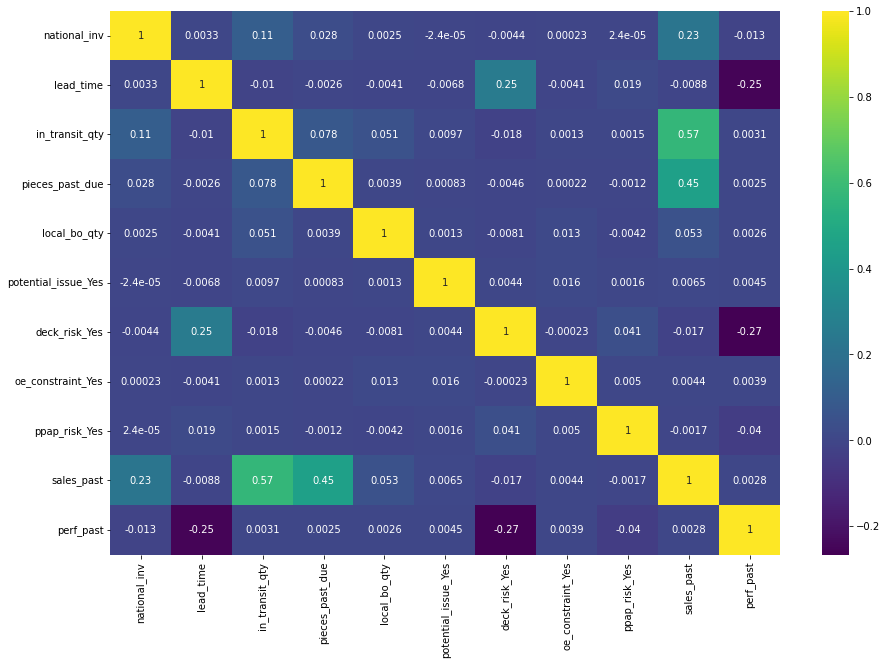

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(X_test.corr(), cmap="viridis", annot=True)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242075 entries, 0 to 242074
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   national_inv         242075 non-null  float64
 1   lead_time            242075 non-null  float64
 2   in_transit_qty       242075 non-null  float64
 3   pieces_past_due      242075 non-null  float64
 4   local_bo_qty         242075 non-null  float64
 5   potential_issue_Yes  242075 non-null  float64
 6   deck_risk_Yes        242075 non-null  float64
 7   oe_constraint_Yes    242075 non-null  float64
 8   ppap_risk_Yes        242075 non-null  float64
 9   sales_past           242075 non-null  float64
 10  perf_past            242075 non-null  float64
dtypes: float64(11)
memory usage: 20.3 MB


In [ ]:
## Recall score on training data
# y_pred_=adaboost.predict(X_train)
# recall_score(y_train, y_pred_)

In [ ]:
## Recall score on training data
# y_pred_=rf.predict(X_train)
# recall_score(y_train, y_pred_) == 0.7517

In [ ]:
## Recall score on test data
# y_pred=adaboost.predict(X_test)
# recall_score(y_test, y_pred), accuracy_score(y_test, y_pred), precision_score(y_test, y_pred)

In [ ]:
# roc_auc_score(y_test, y_pred)

In [ ]:
## Recall score on test data
y_pred=rf.predict(X_test)
recall_score(y_test, y_pred), roc_auc_score(y_test, y_pred)

(0.6436011904761905, 0.7919911235458146)

In [ ]:
accuracy_score(y_test, y_pred), precision_score(y_test, y_pred)

(0.9370856139626149, 0.10811148606424197)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[225115,  14272],
       [   958,   1730]])

In [ ]:
Counter(y_test)

Counter({0: 239387, 1: 2688})

## Feature Importances

In [ ]:
rf.feature_importances_

array([5.17873962e-01, 4.70072755e-02, 4.68191516e-02, 3.40232387e-02,
       6.63547256e-02, 4.19981380e-04, 2.79832126e-02, 8.94551942e-05,
       1.91376913e-02, 2.10213779e-01, 3.00775277e-02])

In [ ]:
X_train.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'pieces_past_due',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'sales_past', 'perf_past'],
      dtype='object')

In [ ]:
imp=dict(zip(X_train.columns ,rf.feature_importances_))

In [ ]:
imp

{'deck_risk_Yes': 0.02798321264009646,
 'in_transit_qty': 0.04681915155417107,
 'lead_time': 0.04700727551173367,
 'local_bo_qty': 0.06635472559186437,
 'national_inv': 0.5178739617640686,
 'oe_constraint_Yes': 8.945519423640851e-05,
 'perf_past': 0.03007752767676713,
 'pieces_past_due': 0.0340232386539464,
 'potential_issue_Yes': 0.0004199813801142986,
 'ppap_risk_Yes': 0.019137691348746714,
 'sales_past': 0.21021377868425478}

In [ ]:
tot=sum(list(imp.values()))
temp=np.array(list(imp.values()))*100
temp

array([5.17873962e+01, 4.70072755e+00, 4.68191516e+00, 3.40232387e+00,
       6.63547256e+00, 4.19981380e-02, 2.79832126e+00, 8.94551942e-03,
       1.91376913e+00, 2.10213779e+01, 3.00775277e+00])

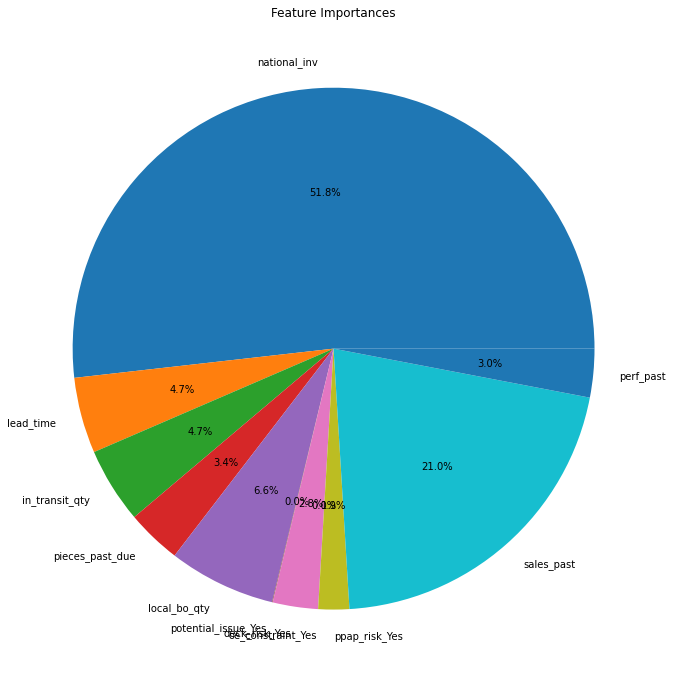

In [ ]:
plt.figure(figsize=(15,12))
plt.pie(x=temp, labels=imp.keys(), autopct='%1.1f%%')
plt.title("Feature Importances")
plt.show()

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "national_inv"].describe()

count    11293.000000
mean        21.432746
std        608.192119
min      -2999.000000
25%          0.000000
50%          1.000000
75%          6.000000
max      29332.000000
Name: national_inv, dtype: float64

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "national_inv"].describe()

count    1.676567e+06
mean     4.993091e+02
std      2.971474e+04
min     -2.725600e+04
25%      4.000000e+00
50%      1.500000e+01
75%      8.100000e+01
max      1.233440e+07
Name: national_inv, dtype: float64

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==1, "sales_past"].describe()

count    11293.000000
mean       113.591030
std        732.676393
min          0.000000
25%          2.750000
50%         11.000000
75%         34.750000
max      20788.250000
Name: sales_past, dtype: float64

In [ ]:
train_data.loc[train_data["went_on_backorder_Yes"]==0, "sales_past"].describe()

count    1.676567e+06
mean     2.755714e+02
std      7.765290e+03
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      2.425000e+01
max      1.700976e+06
Name: sales_past, dtype: float64